# CSC413/2516 Winter 2020

# Generative Adversarial Network (GAN) Tutorial

In this tutorial we'll see how to code a simple Generative Adversarial Network (GAN) to generate handwritten digits that resemble those found in the MNSIT dataset.


## Resources

The following are great resources for learning more about GANs.

1. [Generative Adversarial Nets (Goodfellow et al.)](https://arxiv.org/pdf/1406.2661.pdf) -- the paper that introduced GANs
2. [An Introduction to GANs in Tensorflow](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/)
3. [Generative Models Blog Post from OpenAI](https://blog.openai.com/generative-models/)

Some slides are located [here](https://docs.google.com/presentation/d/1ZNEXW-Llyxb9uAVRGlhfvJKDHTXp_pobs99SAH4ywpU/edit?usp=sharing)

In [0]:
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy.random as npr

# We could use numpy for most things, except computing the gradient
#import numpy as np
import jax.numpy as np
from jax import grad

# We could also swap jax for autograd
#import autograd.numpy as np
#from autograd import grad

#%matplotlib inline

## Load Dataset

In [3]:
def load_mnist():
  from tensorflow.examples.tutorials.mnist import input_data

  mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

  X_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
  y_train = mnist.train.labels

  X_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
  y_test = mnist.test.labels

  del mnist
  return X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1)

train_images, train_labels, test_images, test_labels = load_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Utility Functions

In [0]:
def init_bias(scale, output_size):
    return scale * npr.randn(output_size)

def init_weight(scale, input_size, output_size):
    return scale * npr.randn(input_size, output_size)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def binary_cross_entropy(outputs, targets):
    # loss(o,t)=−1/n∑i(t[i]∗log(o[i])+(1−t[i])∗log(1−o[i]))
    
    loss = np.sum(-(targets * np.log(outputs + 1e-6)) - ((1 - targets) * np.log(1 - outputs + 1e-6)))
    return loss / outputs.shape[0]

# Define the Generator

In [0]:
def init_G_params(noise_size, image_size, scale=0.001):
    return {
            'G_fc1_W': init_weight(scale, noise_size, 400),
            'G_fc1_b': init_bias(scale, 400),
            #'G_fc2_W': init_weight(scale, 200, 400),
            #'G_fc2_b': init_bias(scale, 400),
            #'G_fc3_W': init_weight(scale, 400, image_size),
            'G_fc3_W': init_weight(scale, 400, image_size),
            'G_fc3_b': init_bias(scale, image_size)
           }

def G(params, z):
    """Generates a batch of images from random noise vectors z.
    
    Input: A batch of noise samples, arranged in a matrix of dimension BATCH_SIZE x NOISE_DIM
    Output: A batch of generated images, arranged in a matrix of dimension BATCH_SIZE x IMAGE_SIZE
    """
    G_params = params['G_params']
    x = np.dot(z, G_params['G_fc1_W']) + G_params['G_fc1_b']
    #x = batch_normalize(x)
    x = relu(x)
    
    #x = np.dot(x, G_params['G_fc2_W']) + G_params['G_fc2_b']
    #x = batch_normalize(x)
    #x = relu(x)
    
    output = np.dot(x, G_params['G_fc3_W']) + G_params['G_fc3_b']
    return output

## Define the Discriminator

In [0]:
def init_D_params(image_size, output_size, scale=0.001):
     return {
             'D_fc1_W': init_weight(scale, image_size, 400),
             'D_fc1_b': init_bias(scale, 400),
             #'D_fc2_W': init_weight(scale, 400, 200),
             #'D_fc2_b': init_bias(scale, 200),
             #'D_fc3_W': init_weight(scale, 200, output_size),
             'D_fc3_W': init_weight(scale, 400, output_size),
             'D_fc3_b': init_bias(scale, output_size)
            }

def D(params, x):
    """Takes a batch of images x and returns a batch of scores that indicate how confident the discriminator
    is that the each image is real.
    
    Input: A batch of images x, in a matrix of dimension BATCH_SIZE x IMAGE_SIZE
    Output: A batch of real/fake scores, in a matrix of dimension BATCH_SIZE x 1
    """
    D_params = params['D_params']
    y = np.dot(x, D_params['D_fc1_W']) + D_params['D_fc1_b']
    #y = batch_normalize(y)
    y = relu(y)
    
    #y = np.dot(y, D_params['D_fc2_W']) + D_params['D_fc2_b']
    #y = batch_normalize(y)
    #y = relu(y)
    
    output = np.dot(y, D_params['D_fc3_W']) + D_params['D_fc3_b']
    output = sigmoid(output)
    return output

## Define the loss functions and gradient functions.

In [0]:
def D_loss(params, real_images, fake_images):
    D_real_out = D(params, real_images)
    D_fake_out = D(params, fake_images)
    
    D_real_loss = binary_cross_entropy(D_real_out, np.ones(batch_size))
    D_fake_loss = binary_cross_entropy(D_fake_out, np.zeros(batch_size))

    D_total_loss = D_real_loss + D_fake_loss
    return D_total_loss


def G_loss(params):
    # Sample random noise from a Gaussian distribution
    z = npr.randn(batch_size, noise_dimension)
    fake_images = G(params, z)
    
    D_fake_out = D(params, fake_images)

    # The generator wants to fool the discriminator; that is, it wants the discriminator to assign high 
    # probability (close to 1) to the fake images it generates.
    loss = binary_cross_entropy(D_fake_out, np.ones(batch_size))
    #loss = -binary_cross_entropy(D_fake_out, np.zeros(batch_size))
    return loss

D_loss_grad, G_loss_grad = grad(D_loss), grad(G_loss)

### Prepare to show generated samples during training

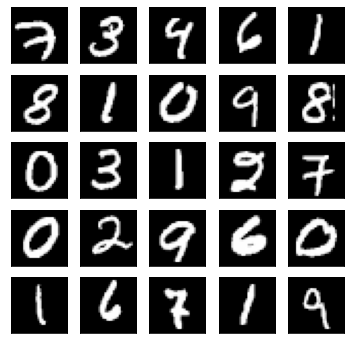

In [8]:
image_width, image_length, image_channels = 28, 28, 1
num_test_samples = 25 
size_figure_grid = int(math.sqrt(num_test_samples))

def display_samples(ax, image_matrix, num_samples=25):
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    # reshaped_generated_images = fake_images.view(batch_size, 28, 28)
    
    for k in range(num_test_samples):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i,j].cla()
        ax[i,j].imshow(image_matrix[k,:].reshape(image_width, image_length), cmap='Greys_r')
    
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
display_samples(ax, train_images[:num_test_samples], num_samples=num_test_samples)

### Train the GAN

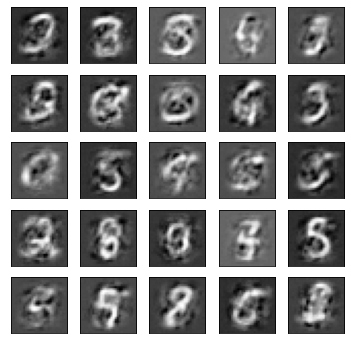

Epoch 9, Iteration 5480
D loss = 54.36766815185547
G loss = 203.771240234375


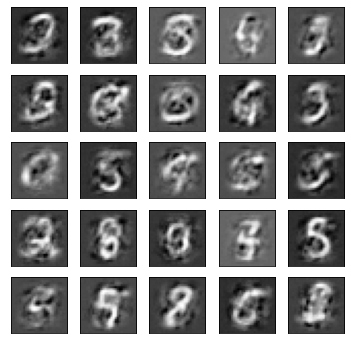

In [9]:
image_size = image_width * image_length * image_channels

# HYPERPARAMETERS
noise_dimension = 20  # Play with this latent dimension
# You could also play with the latent distribution.  Right now its Gaussian.
param_scale = 0.001  # Play with this initialization scale
# You can also play with the initialization distribution in init_weights and init_biases
params = {
        'G_params': init_G_params(noise_dimension, image_size, param_scale),
        'D_params': init_D_params(image_size, 1, param_scale)
    }
# Play with the architecture inside init_G_params, G, init_D_params, D
# Ex., # of hidden layers, connectivity, activation, if we use batch norm, ...

# You can also play with the choice of loss function in G_loss and D_loss

# TRAINING HYPERPARAMETERS
num_epochs = 10  # Play with this.  Whats a good stopping condition?
batch_size = 100  # Play with this
learning_rate = 0.001  # Play with this
# Right now we use SGD for both G and D. You could try other optimizers
# You can try D & G using different optimizers with different parameters.
do_alternating = True  # True if we do alternating updates, false for simultaneous
num_D_train = 1 # Play with this
num_G_train = 1 # Play with with

# DIAGNOSTIC PARAMETERS
display_every = 20

fixed_noise = npr.randn(num_test_samples, noise_dimension)
num_batches = int(math.ceil(train_images.shape[0] / batch_size))
iteration = 0
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for epoch in range(num_epochs):
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        
        real_images = train_images[start_index:end_index]
        
        # Sample random noise from a Gaussian distribution
        z = npr.randn(batch_size, noise_dimension)
        fake_images = G(params, z)

        if do_alternating:
          for _ in range(num_D_train):
            D_grad_params = D_loss_grad(params, real_images, fake_images)
            for param in params['D_params']:  # Update the discriminator
                params['D_params'][param] -= learning_rate * D_grad_params['D_params'][param]
          
          for _ in range(num_G_train):
            G_grad_params = G_loss_grad(params)
            for param in params['G_params']:  # Update the generator
                params['G_params'][param] -= learning_rate * G_grad_params['G_params'][param]
        else:  # Do simultaneous updates
          # Compute BOTH gradients first
          D_grad_params = D_loss_grad(params, real_images, fake_images)
          G_grad_params = G_loss_grad(params)
          
          for param in params['D_params']:  # Update the discriminator
              params['D_params'][param] += learning_rate * D_grad_params['D_params'][param]
        
          for param in params['G_params']:  # Update the generator
              params['G_params'][param] -= learning_rate * G_grad_params['G_params'][param]
        
        
        # Show generated samples periodically, to inspect the generator qualitatively
        if iteration % display_every == 0:
            D_total_loss = D_loss(params, real_images, fake_images)
            G_total_loss = G_loss(params)
            
            test_images = G(params, fixed_noise)
            
            plt.cla()
            display_samples(ax, test_images, num_samples=num_test_samples)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print(f"Epoch {epoch}, Iteration {iteration}")
            print(f"D loss = {D_total_loss}")
            print(f"G loss = {G_total_loss}")
        
        iteration += 1

## Conditional GAN, a.k.a. "Give me a 5!"

The vanilla GAN we have just implemented does not take into account the class of an image; thus, while it can produce realistic images that look like ones from the training set, it cannot produce images of a specific, desired class, such as only images of the number 5. We can extend the vanilla GAN by incorporating extra conditioning information, for example to specify which class we want it to generate. To do this, we pass a conditioning vector $c$ to both the generator and discriminator, so they become $G(z, c)$ and $D(x, c)$, respectively. Then the generator $G$ can take into account which class it is supposed to generate, and $D$ can score how realistic a generated image is, given that it is intended to represent a specific class.

Then, the objective function of the discriminator becomes:
$$
J_D = \mathbb{E}_{x \sim p_{data}} [ - \log D(x, c) ] + \mathbb{E}_z [ - \log(1 - D(G(z, c), c)) ]
$$

And the objective function of the generator becomes:
$$
J_G = \mathbb{E}_{z \sim q(z)} [ - \log D(G(z, c), c) ]
$$